In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler

import tqdm.notebook as tq
import warnings
warnings.filterwarnings('ignore')

import utils_cl
%matplotlib notebook
%load_ext autoreload

## Data Preparing

In [2]:
full_df = pd.read_csv("dataset/normalized_data.csv")
full_df.columns = ['timestamp','import_kwh','meter_id','is_fraud','date','import_kwh_shift1','consumption']
full_df.drop(['import_kwh', 'import_kwh_shift1'], axis=1, inplace = True)
full_df['timestamp'] = pd.to_datetime(full_df.timestamp)
full_df.dropna(inplace=True)

In [3]:
df = full_df.groupby(['meter_id', 'date'])['consumption'].mean()
df = pd.DataFrame(df)
df.reset_index(inplace = True)

df['date'] = pd.to_datetime(df.date)
df.set_index('date', inplace=True)

count    455.000000
mean       1.910368
std        0.791290
min        0.636850
25%        1.304743
50%        1.761913
75%        2.293430
max        4.775486
Name: consumption, dtype: float64


<IPython.core.display.Javascript object>


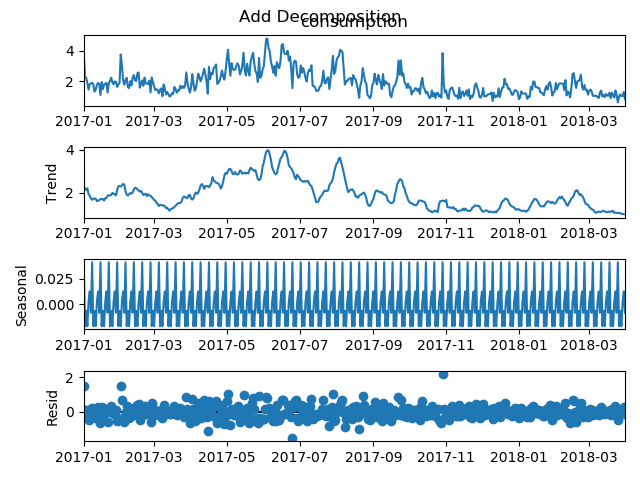

Text(0.5, 0.98, 'Add Decomposition')

In [4]:
# Test 1 sample fraud
sample_fr = df[df.meter_id == 'PP01000103454001']
print(sample_fr['consumption'].describe())
y = sample_fr['consumption']
x = sample_fr.index
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(sample_fr['consumption'], model = 'additive', extrapolate_trend='freq')
result_add.plot().suptitle('Add Decomposition')

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

list_mdd = df.meter_id.unique()
df2 = pd.DataFrame()
fault_mdd = []
for mdd in tq.tqdm(list_mdd) :
    sample_fr = df[df.meter_id == mdd]
    try :
        result_add = seasonal_decompose(sample_fr['consumption'], model = 'additive', extrapolate_trend='freq')
    except :
        fault_mdd.append(mdd)
        continue
    sample_fr['deseasonal'] = result_add.resid
    sample_fr.drop(['consumption'], axis = 1, inplace = True)
    df2 = pd.concat([df2, sample_fr])

In [6]:
df2['START_WEEKDAY'] = df2.index.to_period('W').start_time

In [7]:
df2 = df2[df2['START_WEEKDAY'] != '2016-12-26']
df2 = df2[df2['START_WEEKDAY'] != '2018-03-26']

In [8]:
df2 = df2.groupby(['meter_id', 'START_WEEKDAY'])['deseasonal'].apply(list)

In [9]:
df2 = pd.DataFrame(df2)
df2.reset_index(inplace = True)

In [10]:
df2.head()

,meter_id,START_WEEKDAY,deseasonal
0,PP01000100340001,2017-01-02,"[0.3212745633384745, 0.04002317537240359, -0.1..."
1,PP01000100340001,2017-01-09,"[0.03204132304612953, 0.19598391954323943, -0...."
2,PP01000100340001,2017-01-16,"[-0.1214790654414318, -0.10096256275443354, 0...."
3,PP01000100340001,2017-01-23,"[0.0682605023140748, -0.04394155829060879, -0...."
4,PP01000100340001,2017-01-30,"[-0.11634679281381541, 0.4801489820504065, 0.0..."


In [11]:
from tqdm import tqdm
drop_list = []
for ind in tq.tqdm(range(df2.shape[0])):
    len_list_consumption = len(list(df2[df2.index == ind ]['deseasonal'])[0])
    if len_list_consumption != 7 :
        df2.drop(ind , inplace=True)
        drop_list.append(ind)

In [12]:
len(drop_list)

219

In [13]:
list_col = ['T' + str(i + 2) for i in range(6)] + ['CN']
df2[list_col] = pd.DataFrame(df2.deseasonal.tolist(), index= df2.index)
df2.drop('deseasonal', axis = 1, inplace = True)

In [15]:
df2.head(7)

,meter_id,START_WEEKDAY,T2,T3,T4,T5,T6,T7,CN
0,PP01000100340001,2017-01-02,0.321275,0.040023,-0.185360,-0.097297,0.104045,-0.170828,-0.082016
1,PP01000100340001,2017-01-09,0.032041,0.195984,-0.085221,-0.029924,-0.038465,0.257508,-0.087102
2,PP01000100340001,2017-01-16,-0.121479,-0.100963,0.163844,-0.019069,-0.015114,-0.049732,0.037160
3,PP01000100340001,2017-01-23,0.068261,-0.043942,-0.103193,0.052646,-0.041660,-0.019876,-0.100347
4,PP01000100340001,2017-01-30,-0.116347,0.480149,0.071689,-0.106295,-0.104815,-0.078869,0.087206
5,PP01000100340001,2017-02-06,0.016099,0.203092,-0.265088,0.027258,0.054575,-0.230237,0.112182
6,PP01000100340001,2017-02-13,0.063714,-0.180602,0.215548,-0.124153,-0.062891,0.413819,-0.006201


In [17]:
fraud_milestones = [('PP07000684209001','2017-12-29'),
 ('PP07000670259001','2017-01-03'),
 ('PP07000693227001','2017-08-14'),
 ('PP07000713473001','2017-04-12'),
 ('PP07000662970001','2017-03-02'),
 ('PP07000700839001','2017-05-23'),
 ('PP07000668984001','2017-08-24'),
 ('PP07000683751001','2017-10-25'),
 ('PP07000683750001','2017-10-25'),
 ('PP07000613734001','2017-03-24'),
 ('PP07000673219001','2017-04-24'),
 ('PP07000682085001','2017-10-27'),
 ('PP07000613618001','2017-11-29'),
 ('PP07000600208001','2017-10-05'),
 ('PP07000600209001','2017-10-05'),
 ('PP07000678169001','2017-07-06'),
 ('PP01000134773001','2017-12-12'),
 ('PP01000624985001','2017-12-28'),
 ('PP01000621525001','2017-01-11'),
 ('PP01000117448001','2017-04-14'),
 ('PP01000117849001','2017-10-25'),
 ('PP01000110500001','2017-03-27'),
 ("PP01000103859001","2017-10-30"),
 ('PP01000131431001','2017-04-03'),
 ("PP01000103454001",'2017-08-03'),
 ('PP01000101145001','2017-03-06'),
 ('PP01000140094001','2017-01-09'),
 ('PP01000101975001','2017-02-07'),
 ('PP03000810040001','2017-08-12'),
 ('PP03000832565001','2017-06-13'),
 ('PP03000806717001','2017-07-12'),
 ('PP03000902373001','2017-07-17'),
 ('PP03000809863001','2017-12-19'),
 ('PP03000882852001','2017-12-21'),
 ('PP03000902981001','2017-04-21'),
 ('PP03000804097001','2017-06-24'),
 ('PP03000805922001','2017-09-25'),
 ('PP03000804137001','2017-10-30'),
 ('PP03000904351001','2017-03-28'),
 ('PP03000898466001','2017-06-29'),
 ('PP05000989390001','2017-05-02'),
 ('PP05000948327001','2017-08-10'),
 ('PP05000977900001','2017-01-13'),
 ('PP05000501075001','2017-01-13'),
 ('PP05000501411001','2017-10-13'),
 ('PP05000524904001','2017-04-13'),
 ('PP05000951373001','2017-04-14'),
 ('PP05000967512001','2017-03-15'),
 ('PP05000960339001','2017-03-15'),
 ('PP05000515674001','2017-04-18'),
 ('PP05000967753001','2017-07-20'),
 ('PP05000944240001','2017-05-22'),
 ('PP05000504291001','2017-04-21'),
 ('PP05000968892001','2017-05-22'),
 ('PP05000961578001','2017-05-22'),
 ('PP05000953931001','2017-11-23'),
 ('PP05000502843001','2017-02-24'),
 ('PP05000941329001','2017-11-25'),
 ('PP05000509756001','2017-08-30'),
 ('PP05000524362001','2017-01-04'),
 ('PP05000516894001','2017-04-05'),
 ('PP05000522325001',"2017-12-06"),
 ('PP05000517007001','2017-08-07'),
 ('PP05000515078001','2017-03-09'),
 ('PP05000991348001','2017-05-09'),
 ('PP09000810551001','2017-08-11'),
 ('PP09000884920001','2017-04-11'),
 ('PP09000802199001','2017-09-11'),
 ('PP09000811262001','2017-02-13'),
 ('PP09000120555001','2017-04-17'),
 ('PP09000890287001','2017-02-20'),
 ('PP09000808752001','2017-12-21'),
 ('PP09000817228001','2017-10-24'),
 ('PP09000907245001','2017-11-24'),
 ('PP09000821975001','2017-10-28'),
 ('PP09000837585001','2017-11-28'),
 ('PP09000808816001','2017-12-28'),
 ('PP09000808816001','2017-04-29'),
 ('PP09000892588001','2017-10-31'),
 ('PP09000894390001','2017-10-31'),
 ("PP09000894706001","2017-12-08") 
]

In [18]:
list_fraud = [i[0] for i in fraud_milestones]
list_mdd = df2.meter_id.unique()

In [19]:
df2.shape

(66540, 9)

In [333]:
# for _p in fraud_milestones :
#     if _p[0] in list_mdd:
#         df2.drop(df2[(df2.meter_id == _p[0]) & (df2.START_WEEKDAY > _p[1])].index, inplace=True)

In [20]:
df3 = pd.read_csv("dataset/residual_weekly_consumption.csv")

## Clustering

In [109]:
X_normalized = df2.iloc[:, 2:]

In [108]:
# With scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

scaler = StandardScaler()
X = scaler.fit_transform(df2.iloc[:, 2:])
X = pd.DataFrame(X)
X_normalized = X



In [110]:
from sklearn.cluster import KMeans

distance_used = utils_cl.distance_ED
cluster_number = 3
n_iters = 500

km = KMeans(n_clusters=cluster_number,
            max_iter=n_iters,
            tol = 1e-8,
            random_state=0)

y_km = km.fit_predict(X_normalized)
centroids = km.cluster_centers_

In [111]:
from collections import Counter
Counter(y_km)

Counter({0: 66538, 1: 1, 2: 1})

In [112]:
# distance of members to center in each cluster
dict_DC = {}

for i in range(cluster_number):
    dict_DC[i+1] = []
for i, j in tq.tqdm_notebook(enumerate(y_km), total = len(y_km)):        
    dict_DC[j+1].append(distance_used(centroids[j], X_normalized.iloc[i, :]))

In [113]:
# radius of each cluster
quantile_radius = []
percentile = 0.98
for j in range(cluster_number):
    quantile_radius.append(pd.DataFrame(dict_DC[j+1]).quantile(percentile, axis = 0)[0])
average_radius = []
for j in range(cluster_number):
    average_radius.append(sum(dict_DC[j+1])/len(dict_DC[j+1]))
max_radius = []
for j in range(cluster_number):
    max_radius.append(max(dict_DC[j+1]))

print("average_radius :",  average_radius)
print("max_radius :",  max_radius)
print("quantile_radius :",  quantile_radius)

average_radius : [0.8173257189472628, 0.0, 0.0]
max_radius : [53.522069172913156, 0.0, 0.0]
quantile_radius : [3.780327456092512, 0.0, 0.0]


In [114]:
# KM
def test_fraud_cluster(X_sample, cluster_belong, radius_cent, thresh_KM):
    dist2cent = distance_used(X_sample, centroids[cluster_belong - 1])
    is_fraud = (dist2cent > radius_cent[cluster_belong-1] * thresh_KM)
    return is_fraud

def prediction_result(test_set, radius_cent, thresh_KM = 1.0):
    N = test_set.shape[0]
    mdd_fraud_1week = []
    Y_predict = []
    ind_fraud_predicted = []
    count_fraud_predicted = [0]*cluster_number
    for i in tq.tqdm_notebook(range(N)):
        X_sample = test_set.iloc[i, :]
        cluster_belong = y_km[i] + 1
        test_result = test_fraud_cluster(X_sample, cluster_belong, radius_cent, thresh_KM)
        if test_result == True :
            count_fraud_predicted[cluster_belong-1] += 1
            mdd_fraud_1week.append(df2.iloc[i, 0])
            ind_fraud_predicted.append(i)
        Y_predict.append(test_result)
    return list(set(mdd_fraud_1week)), Y_predict, ind_fraud_predicted,count_fraud_predicted

In [115]:
test_set = X_normalized
radius_cent = quantile_radius
thresh_KM = 1

mdd_fraud_1week, Y_predict, ind_fraud_predicted, count_fraud_predicted = prediction_result(test_set, radius_cent, thresh_KM)

In [116]:
count_fraud_predicted

[1331, 0, 0]

In [117]:
len(mdd_fraud_1week)

162

## Pred

In [118]:
test_df = pd.DataFrame()
test_df['meter_id'] = df2.meter_id
test_df['PRED'] = Y_predict
test_df = test_df.groupby(['meter_id'])['PRED'].apply(list)

In [128]:
consecutive_week = 2

def test_consecutive_week(l):
    n = len(l)
    for i in range(n) :
        if l[i] == True:
            if sum(l[i : i+consecutive_week]) == consecutive_week:
                return True
        else :
            continue
    return False

mdd_fraud_n_week = []
for i in range(test_df.shape[0]):
    l = test_df[i]
    if test_consecutive_week(l):
        mdd_fraud_n_week.append(test_df.index[i])
        

In [129]:
len(mdd_fraud_n_week)

77

In [130]:
n_fraud = len(set(mdd_fraud_n_week) & set(list_fraud))
print(n_fraud)

13


In [131]:
n_fraud/len(list_fraud)

0.16049382716049382

In [127]:
(len(mdd_fraud_n_week) - n_fraud)/1000

0.027

In [279]:
# Result
# 30% - 7%  - 4
# 38% - 10% - 3
# 47% - 18% - 2

In [246]:
mdd_fraud_n_week

['PP09000836297001']

## Tunning percentile quantile

In [247]:
percentile_list = list(np.arange(0.9, 0.99, 0.01))
tun_res = []
for _p in tq.tqdm_notebook(percentile_list):
    quantile_radius = []
    for j in range(cluster_number):
        quantile_radius.append(pd.DataFrame(dict_DC[j+1]).quantile(_p, axis = 0)[0])
    test_set = X_normalized
    radius_cent = quantile_radius
    thresh_KM = 1
    mdd_fraud_1week, Y_predict, ind_fraud_predicted, count_fraud_predicted = prediction_result(test_set, radius_cent, thresh_KM)
    test_df = pd.DataFrame()
    test_df['meter_id'] = df2.meter_id
    test_df['PRED'] = Y_predict
    test_df = test_df.groupby(['meter_id'])['PRED'].apply(list)
    consecutive_week = 1
    mdd_fraud_n_week = []
    for i in range(test_df.shape[0]):
        l = test_df[i]
        if test_consecutive_week(l):
            mdd_fraud_n_week.append(test_df.index[i])

    n_fraud = len(set(mdd_fraud_n_week) & set(list_fraud))
    save_i = n_fraud/len(list_fraud)
    save_j = (len(mdd_fraud_n_week) - n_fraud)/1000
    tun_res.append((save_i, save_j))

KeyboardInterrupt: 

In [203]:
tun_res

[(0.5925925925925926, 0.987),
 (0.5802469135802469, 0.983),
 (0.5555555555555556, 0.978),
 (0.5555555555555556, 0.965),
 (0.5185185185185185, 0.942),
 (0.49382716049382713, 0.918),
 (0.4444444444444444, 0.878),
 (0.43209876543209874, 0.804),
 (0.2962962962962963, 0.686)]